In [2]:
import numpy as np
from matplotlib import pyplot as plt
from ts_modelling.data_producer import DataProducer
from ts_modelling.simple_experiment import SimpleExp
from argparse import Namespace
import yaml
import torch
%matplotlib inline

with open('args.yaml', 'r') as file:
    config = yaml.safe_load(file)
args = Namespace(**config)

In [6]:
length = 365*24
args.data_path = 'even_sine.csv'

dp = DataProducer(length=length, n_vars=1, path=args.root_path, noise_amp=0.5)
dp.add_sine([(2/(24*7), 1), (4/(24*7), 1)])
dp.generate_csv(args.data_path)

exp = SimpleExp(args)
exp.pretrain_model()
exp.train_predict_head()
exp.finetune_model()

Use CPU
supervised head
Trainable parameters:      106508
Total parameters:          106509
Training on data: even_sine.csv
train 5606
val 686
test 1561
Validation loss decreased (inf --> 0.789066).  Saving model ...
Updating learning rate to 2.8083122651248297e-05
Total training time: 0 minutes 4.100135087966919 seconds
Trainable parameters:      712896
Total parameters:          817857
Training on data: even_sine.csv
train 5606
val 686
test 1561
Validation loss decreased (inf --> 0.032377).  Saving model ...
Updating learning rate to 2.8083122651248297e-05
Total training time: 0 minutes 2.50844407081604 seconds
Trainable parameters:      817857
Total parameters:          817857
Training on data: even_sine.csv
train 5606
val 686
test 1561
Validation loss decreased (inf --> 0.030351).  Saving model ...
Updating learning rate to 2.8083122651248297e-05
Total training time: 0 minutes 4.934921979904175 seconds


In [11]:
args.model_name

'PTST_test'

In [8]:
args.data_path = 'odd_sine.csv'
dp = DataProducer(length=length, n_vars=1, path=args.root_path, noise_amp=0.5)
dp.add_sine([(3/(24*7), 1), (5/(24*7), 1)])
dp.generate_csv(args.data_path)
exp.test(args.data_path)

test 1561


channel 0: signal_1, position: 0


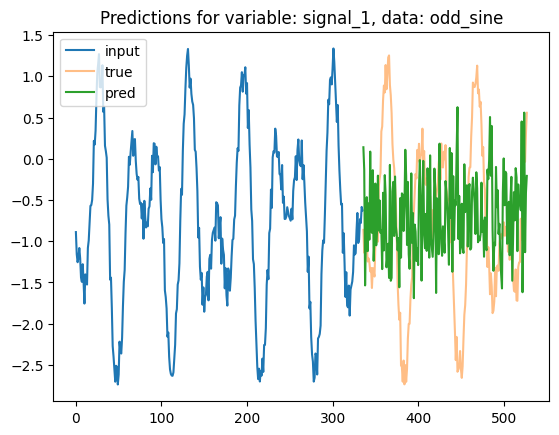

channel 0: signal_1, position: 512


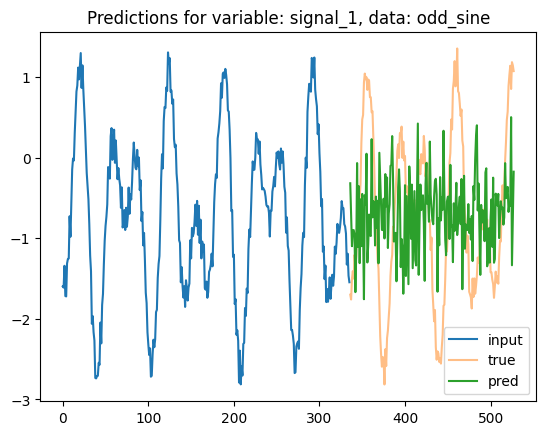

channel 0: signal_1, position: 1024


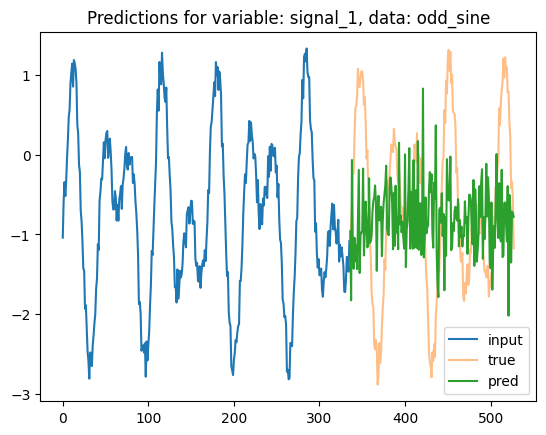

channel 0: signal_1, position: 0


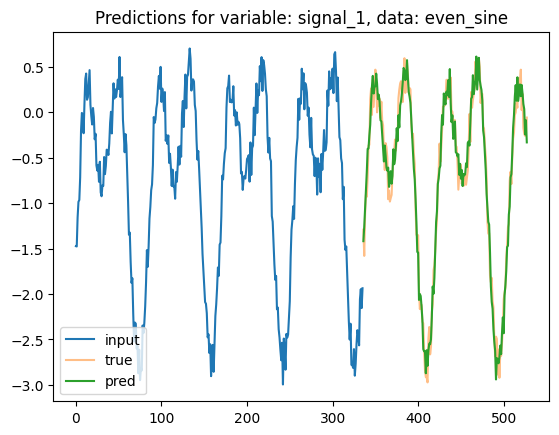

channel 0: signal_1, position: 512


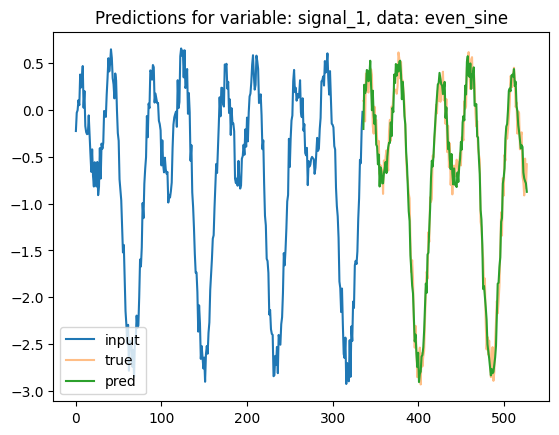

channel 0: signal_1, position: 1024


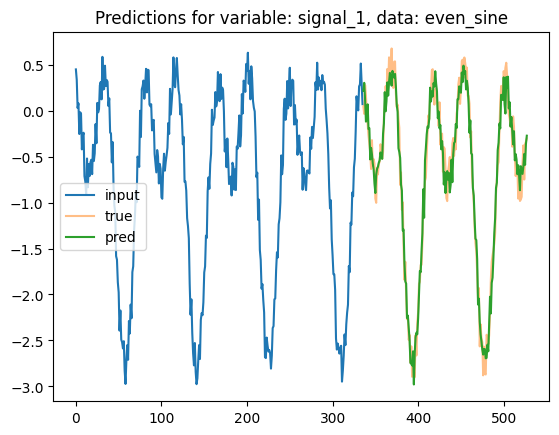

channel 0: signal_1, position: 0


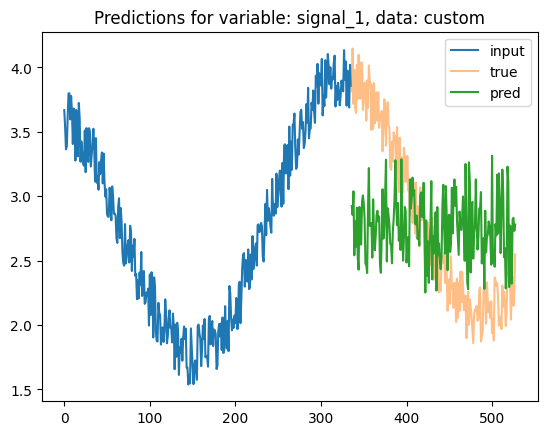

channel 0: signal_1, position: 266


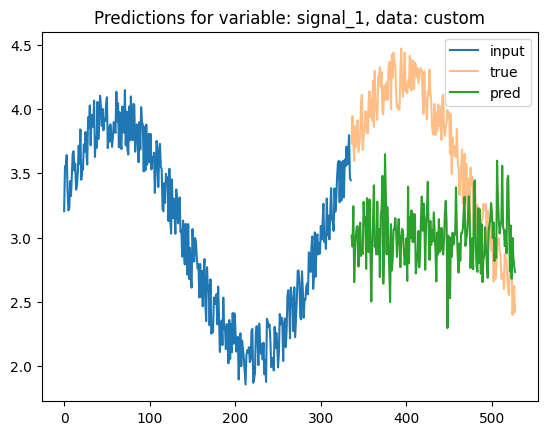

channel 0: signal_1, position: 532


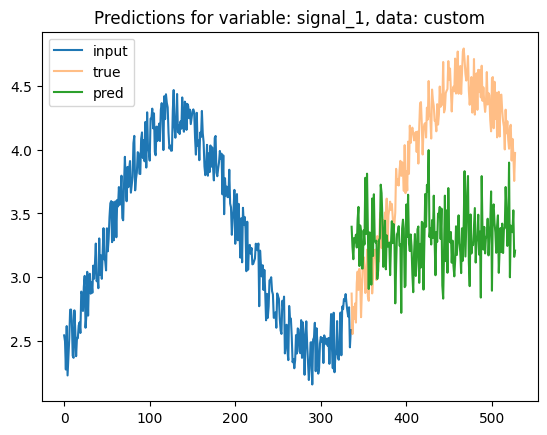

In [9]:
exp.plot_preds()